In [1]:
import sys
!{sys.executable} -m pip install gym pygame

In [2]:
import gym
import pygame
import tqdm

env = gym.make("CartPole-v1")

print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

Action space: Discrete(2)
Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
env.reset()

done = False
total_reward = 0
while not done:
   env.render()
   obs, rew, done, info = env.step(env.action_space.sample())
   total_reward += rew
   print(f"{obs} -> {rew}")
print(f"Total reward: {total_reward}")

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for 

[-0.03634352  0.18985145  0.0123963  -0.29328677] -> 1.0
[-0.03254649  0.38479447  0.00653057 -0.5820344 ] -> 1.0
[-0.0248506   0.18958165 -0.00511012 -0.28730145] -> 1.0
[-0.02105897  0.3847761  -0.01085615 -0.58159167] -> 1.0
[-0.01336345  0.18980792 -0.02248798 -0.2923483 ] -> 1.0
[-0.00956729  0.38524318 -0.02833495 -0.592038  ] -> 1.0
[-0.00186242  0.19052911 -0.04017571 -0.30841348] -> 1.0
[ 0.00194816  0.3861998  -0.04634398 -0.6134911 ] -> 1.0
[ 0.00967215  0.19175506 -0.0586138  -0.33575743] -> 1.0
[ 0.01350725 -0.00248588 -0.06532895 -0.06211898] -> 1.0
[ 0.01345754 -0.19661328 -0.06657133  0.20925793] -> 1.0
[ 0.00952527 -0.00060573 -0.06238617 -0.10365967] -> 1.0
[ 0.00951316 -0.19478072 -0.06445936  0.16870655] -> 1.0
[ 0.00561754 -0.38892365 -0.06108523  0.4403782 ] -> 1.0
[-0.00216093 -0.5831303  -0.05227767  0.713197  ] -> 1.0
[-0.01382354 -0.38732502 -0.03801373  0.4045277 ] -> 1.0
[-0.02157004 -0.19168517 -0.02992317  0.10010657] -> 1.0
[-0.02540374  0.00385256 -0.027

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

num_inputs = 4
num_actions = 2

model = keras.Sequential([
    keras.layers.Dense(128, activation="relu",input_shape=(num_inputs,)),
    keras.layers.Dense(num_actions, activation="softmax")
])

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01))

In [5]:
def run_episode(max_steps_per_episode = 10000,render=False):
    states, actions, probs, rewards = [],[],[],[]
    state = env.reset()
    for _ in range(max_steps_per_episode):
        if render:
            env.render()
        action_probs = model(np.expand_dims(state,0))[0]
        action = np.random.choice(num_actions, p=np.squeeze(action_probs))
        nstate, reward, done, info = env.step(action)
        if done:
            break
        states.append(state)
        actions.append(action)
        probs.append(action_probs)
        rewards.append(reward)
        state = nstate
    return np.vstack(states), np.vstack(actions), np.vstack(probs), np.vstack(rewards)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
s,a,p,r = run_episode()
print(f"Total reward: {np.sum(r)}")

Total reward: 22.0


In [7]:
eps = 0.0001

def discounted_rewards(rewards,gamma=0.99,normalize=True):
    ret = []
    s = 0
    for r in rewards[::-1]:
        s = r + gamma * s
        ret.insert(0, s)
    if normalize:
        ret = (ret-np.mean(ret))/(np.std(ret)+eps)
    return ret

0 -> 32.0
100 -> 196.0
200 -> 307.0


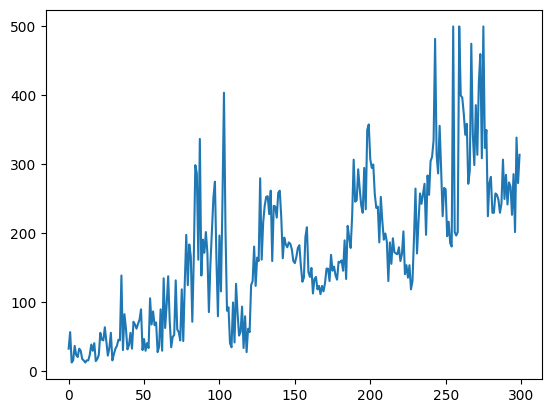

In [8]:
alpha = 1e-4

history = []
for epoch in range(300):
    states, actions, probs, rewards = run_episode()
    one_hot_actions = np.eye(2)[actions.T][0]
    gradients = one_hot_actions-probs
    dr = discounted_rewards(rewards)
    gradients *= dr
    target = alpha*np.vstack([gradients])+probs
    model.train_on_batch(states,target)
    history.append(np.sum(rewards))
    if epoch%100==0:
        print(f"{epoch} -> {np.sum(rewards)}")

plt.plot(history)

In [9]:
import gym

# Create the environment
env = gym.make('CartPole-v1')

# Run an episode
observation = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)

# Close the environment
env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [10]:
env.render()

/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [11]:
_ = run_episode(render=True)

In [12]:
num_inputs = 4
num_actions = 2
num_hidden = 128

inputs = keras.layers.Input(shape=(num_inputs,))
common = keras.layers.Dense(num_hidden, activation="relu")(inputs)
action = keras.layers.Dense(num_actions, activation="softmax")(common)
critic = keras.layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])

In [13]:
def run_episode(max_steps_per_episode = 10000,render=False):
    states, actions, probs, rewards, critic = [],[],[],[],[]
    state = env.reset()
    for _ in range(max_steps_per_episode):
        if render:
            env.render()
        action_probs, est_rew = model(np.expand_dims(state,0))
        action = np.random.choice(num_actions, p=np.squeeze(action_probs[0]))
        nstate, reward, done, info = env.step(action)
        if done:
            break
        states.append(state)
        actions.append(action)
        probs.append(tf.math.log(action_probs[0,action]))
        rewards.append(reward)
        critic.append(est_rew[0,0])
        state = nstate
    return states, actions, probs, rewards, critic

In [14]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
episode_count = 0
running_reward = 0

while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        _,_,action_probs, rewards, critic_values = run_episode()
        episode_reward = np.sum(rewards)

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate discounted rewards that will be labels for our critic
        dr = discounted_rewards(rewards)

        # Calculating loss values to update our network
        actor_losses = []
        critic_losses = []
        for log_prob, value, rew in zip(action_probs, critic_values, dr):
            # When we took the action with probability `log_prob`, we received discounted reward of `rew`,
            # while critic predicted it to be `value`
            # First we calculate actor loss, to make actor predict actions that lead to higher rewards
            diff = rew - value
            actor_losses.append(-log_prob * diff)

            # The critic loss is to minimize the difference between predicted reward `value` and actual
            # discounted reward `rew`
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(rew, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))

    if running_reward > 195:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

running reward: 12.74 at episode 10
running reward: 15.93 at episode 20
running reward: 15.16 at episode 30
running reward: 15.16 at episode 40
running reward: 17.53 at episode 50
running reward: 22.95 at episode 60
running reward: 30.11 at episode 70
running reward: 35.52 at episode 80
running reward: 32.44 at episode 90
running reward: 29.92 at episode 100
running reward: 35.61 at episode 110
running reward: 42.74 at episode 120
running reward: 44.46 at episode 130
running reward: 44.74 at episode 140
running reward: 51.37 at episode 150
running reward: 60.58 at episode 160
running reward: 81.09 at episode 170
running reward: 130.16 at episode 180
running reward: 140.69 at episode 190
running reward: 92.01 at episode 200
running reward: 71.10 at episode 210
running reward: 54.30 at episode 220
running reward: 52.13 at episode 230
running reward: 92.43 at episode 240
running reward: 131.62 at episode 250
running reward: 119.97 at episode 260
running reward: 120.06 at episode 270
runni

In [15]:
_ = run_episode(render=True)

In [16]:
env.close()